# YoloV8 No Data Augmentation Evaluation of Training

## Evaluation of training metrics

In the following Notebook, the results of different YOLOv8 models have been plotted. All of them show a curve over the 100 epochs that shows an improvement in training loss over the different subtasks (box prediction, segmentation, class prediction). The metrics shown in the plots are all on the validation set but the training loss is also plotted. We can see that the base model is very good already on all the plots and adding some data augmentation techniques can actually decrease performance. This is due to automatic preprocessing and data augmentation as default steps in YOLOv8. After some time looking into the source code of YOLOv8 under their repository, it becomes clear that data augmentation is a default preset in YOLOv8 training and spans a bunch of augmentation techniques. This can be seen in the ["build_transforms()" function in the YOLOv8 dataset file](https://github.com/ultralytics/ultralytics/blob/6391c60089ef4c0f8876524d9421009ee4360a65/ultralytics/yolo/data/dataset.py) and the ["load_image()" function in the YOLOv8 base data file](https://github.com/ultralytics/ultralytics/blob/6391c60089ef4c0f8876524d9421009ee4360a65/ultralytics/yolo/data/base.py). In the latter, images are loaded and resized. In the former, there are a couple of default augmentation techniques like the ["mosaic" data augmentation](https://blog.roboflow.com/yolov4-data-augmentation/), normalization, and some more that are defined in the "v8_transforms()" function in the [YOLOv8 augment file](https://github.com/ultralytics/ultralytics/blob/6391c60089ef4c0f8876524d9421009ee4360a65/ultralytics/yolo/data/augment.py#L762). In general, the images are resized to the next multiple of 32 and also padded. This is easy for our 419 x 419 data.

Back to the metrics, we, therefore, see some data augmentation runs underperforming in comparison to no augmentation runs while the base model is already really good. We can argue that YOLOv8 is a consumer-ready technology where you don’t need to test data augmentation that much. If we check the bar plot below the training run plots, we can see that the “Base XL” model is the best by both mAP50(M) (= mAP 50 for the masks) and mAP50(B) (= mAP 50 for the boxes). This is the largest model provided by YOLOv8, all other models were trained on YOLOv8 small. Interesting to notice is that the mAPs become worse at almost the same rate. The bar plot is ordered by mAP50(m). “Base XL” is closely followed by “llr_0.001 retrained augment full“. This is a test run where the learning rate was adjusted to be a bit smaller. ”Retrain“ stands for the retraining of this test run since in the first ”llr_0.001“ run, the lr gets automatically adjusted by some learning rate scheduler and ends up at the same learning rate as the base model. In "Retrain" it doesn't end at the same lr as the base model. ”Augment Full“ is the augmentation strategy. ”Full“ means that the model was trained on a similar augmentation strategy as the baseline Mask R-CNN from the paper. Since ”Edge-Detect” and ”Color Enhancement” is not clearly defined in the paper, “Edge Detect” is not included, and “Color Enhancement” is replaced by an “RGB Shift“. This can be seen in the notebook ”yolov8_overfit.ipynb” where all models were trained. There, the augmentation probabilities for each run can also be seen. It is interesting to note that while other augmentations made the model train worse, the full augmentation with a smaller learning rate improved the training results, even though the data is automatically augmented by YOLOv8. This is also the case with using AdamW as the optimizer together with the full augmentation or setting the YOLOv8 parameter "pretrained" to "True". Changing the learning rate has therefore an impact on how the model looks at the augmented data. Only changing the hyperparameters (SGD to AdamW, lr times 10, etc.) doesn’t improve the training. Using the base model without any hyperparameter tuning with data augmentation also doesn’t improve the training. Using 5 times the training data (copying each image 5 times) and using augmentation also doesn’t improve the training but this can probably be improved by adjusting other hyperparameters. Interestingly, dropout being set to 0.3 improves the validation mAPs by almost 1% compared to the base YOLOv8. This falls under regularization. To really push this model, using the xl model with an adjustment of the learning rate, dropout and maybe copying some training data, could improve the mAP further but this is left out for future test runs. The results are already very good and the base model outperforms the best Mask R-CNN model from the paper by over 10%. Roboflow (the website where the data was uploaded) also provides a free model training step. In their base model, the mAPs were around 93%. This has already been beaten by adjusting the small base YOLOv8 model or training the xl model.

Other info: 
Changing the learning rate to a lower one surprisingly makes the baseline learn faster. We would assume that a higher learning rate would learn faster but not reach the best global minimum while the smaller learning rate gets stuck. This is not the case here. We can see for every model that after 100 epochs, training stagnates but at the 90 epoch mark there is an interesting spike in training loss in all models for some reason followed by a quick drop again. This is not discernible in the validation metrics.

Unfortunately, the validation loss doesn’t get tracked correctly by YOLOv8. This metric is lost due to some internal error that wasn’t looked at further. The model is probably overfitting since dropout helped in improving the mAPs.

### Confusion Matrices

Plotting the confusion matrices per model, it becomes clear that most false positives or false negatives are for the background class. This is also the case in the paper and the Mask R-CNN model. Most YOLOv8 models also have a false positive in powdery mildew fruit where the actual label was gray mold. Other common occurrences are hard to see. In the base model small and xl, gray mold as the ground truth is not predicted correctly sometimes.

### Manual evaluation of predictions

For each model, YOLOv8 automatically saves a couple of validation images with their ground truth labels and predictions (boxes, masks, classes). In general, the base model predicts the boxes in pretty accurate places and the classes are also very accurate. The base model sometimes fails to put a correct and detailed mask on every disease in the picture. If you browse ./runs/segment/base_predict, it becomes clear, that diseases closely together are not always masked correctly. This is probably due to the fact that the ground truth labels (in each .runs/segment/ model folder there are batches of ground truth labels) sometimes put overlapping boxes for the same disease where that disease appears in clusters. It is therefore more than likely that the model doesn’t know when to use overlapping boxes for clusters of the disease or one single big box for all the clusters since they are close together. Some of the masks also don’t span all the clusters of disease spots. All in all, the prediction of classes is pretty good nonetheless.

Ultralytics YOLOv8.0.2 🚀 Python-3.11.3 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24238MiB)
Setup complete ✅ (12 CPUs, 23.4 GB RAM, 94.0/95.6 GB disk)


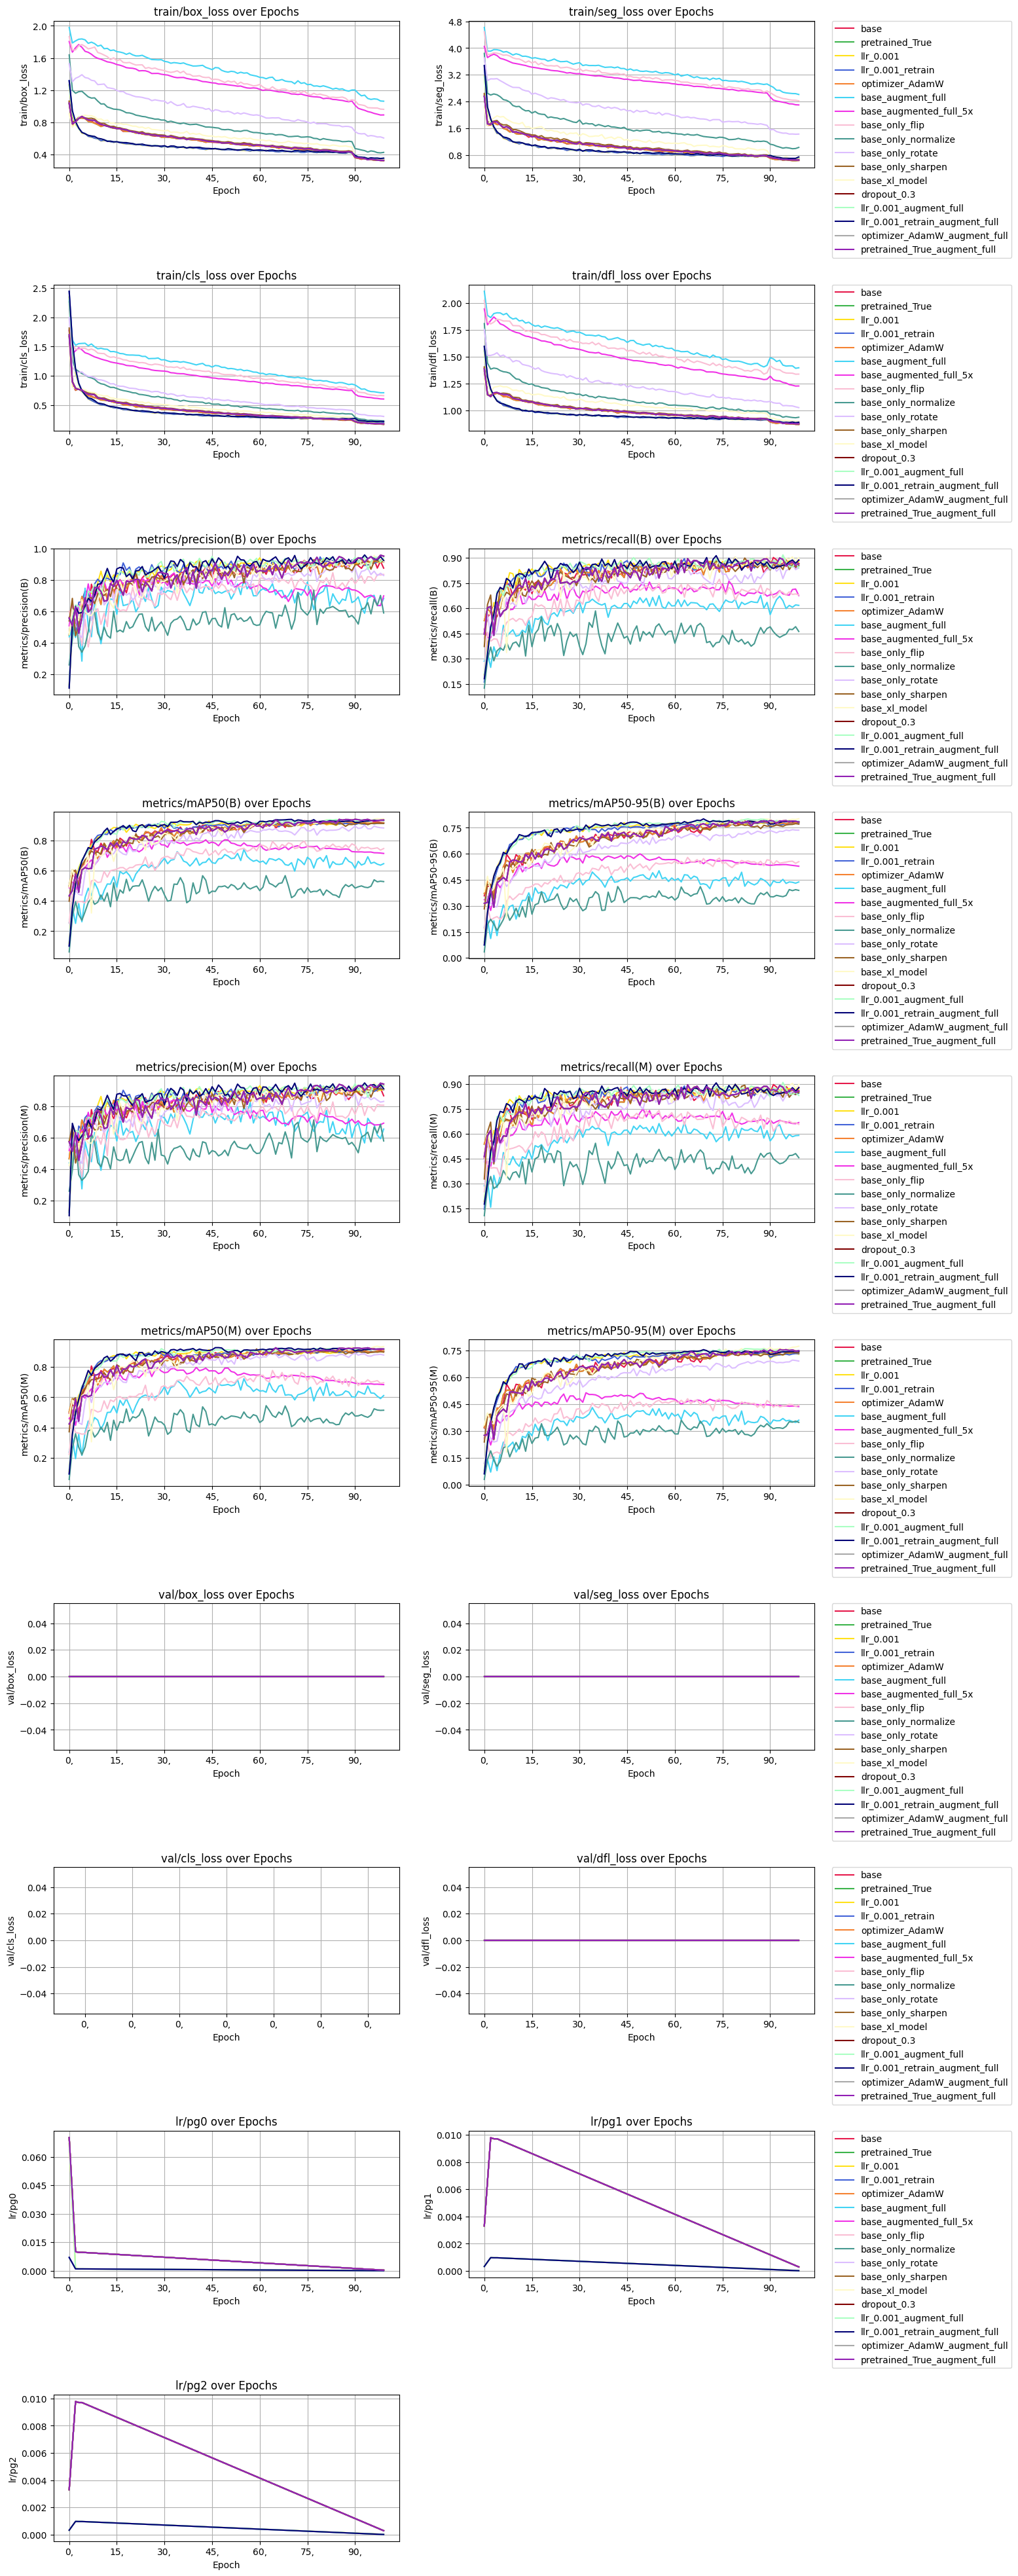

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython import display
display.clear_output()
import ultralytics
ultralytics.checks()
from IPython.display import display
import numpy as np
import matplotlib.image as mpimg
from matplotlib import gridspec

# each dir is splitted using "/" to get the label for the legend in the plots
model_dirs = ["../runs/segment/base", "../runs/segment/pretrained_True", 
              "../runs/segment/llr_0.001", "../runs/segment/llr_0.001_retrain", "../runs/segment/optimizer_AdamW", 
              "../runs/segment/base_augment_full", "../runs/segment/base_augmented_full_5x", "../runs/segment/base_only_flip", 
              "../runs/segment/base_only_normalize", "../runs/segment/base_only_rotate", "../runs/segment/base_only_sharpen",
              "../runs/segment/base_xl_model", "../runs/segment/dropout_0.3", "../runs/segment/llr_0.001_augment_full",
              "../runs/segment/llr_0.001_retrain_augment_full", "../runs/segment/optimizer_AdamW_augment_full", "../runs/segment/pretrained_True_augment_full"]

metrics = ['train/box_loss', 'train/seg_loss', 'train/cls_loss', 'train/dfl_loss',
           'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 
           'metrics/precision(M)', 'metrics/recall(M)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)', 
           'val/box_loss', 'val/seg_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1' ,'lr/pg2']

num_rows = int(np.ceil(len(metrics) / 2))
num_cols = 2

import matplotlib.pyplot as plt

# https://sashamaps.net/docs/resources/20-colors/
colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#42d4f4', '#f032e6', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#000075', '#a9a9a9', '#911eb4', '#000000']
assert len(colors) >= len(model_dirs)

# Assign each model directory a color
dir_colors = {dir: color for dir, color in zip(model_dirs, colors)}

# Create a subplot for each metric
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
plt.subplots_adjust(hspace=0.8, wspace=0.2)

# Loop through each model directory
for model_dir in model_dirs:
    results_path = os.path.join(model_dir, "results.csv")
    df = pd.read_csv(results_path, delim_whitespace=True)
    df.columns = df.columns.str.rstrip(',')

    # Loop through each metric and plot it
    for i, metric in enumerate(metrics):
        row = i // num_cols
        col = i % num_cols
        if not pd.api.types.is_numeric_dtype(df[metric]):
            df[metric] = df[metric].str.rstrip(",").astype(float)
        axs[row, col].plot(df['epoch'], df[metric], label=model_dir.split("/")[-1], color=dir_colors[model_dir])
        axs[row, col].set_xlabel('Epoch')
        axs[row, col].set_ylabel(metric)
        axs[row, col].set_title(f'{metric} over Epochs')
        if col == 1:
            axs[row, col].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        axs[row, col].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        axs[row, col].yaxis.set_major_locator(plt.MaxNLocator(nbins=6))
        axs[row, col].grid(True)

# If there are fewer metrics than subplots, remove the extra subplots
if len(metrics) < num_rows * num_cols:
    for i in range(len(metrics), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axs[row, col])
        
plt.show()


In [14]:
results = {}

# Loop through each model directory
for model_dir in model_dirs:
    # Define the path of the results.csv file
    results_path = os.path.join(model_dir, "results.csv")

    # Load the results.csv file into a DataFrame
    df = pd.read_csv(results_path, delim_whitespace=True)
    
    # Ensure the columns of interest are numeric
    df["metrics/mAP50(M)"] = df["metrics/mAP50(M),"].str.replace(',', '').astype(float)
    df["metrics/mAP50(B)"] = df["metrics/mAP50(B),"].str.replace(',', '').astype(float)
    
    # Find the maximum values
    max_mAP50_M = df["metrics/mAP50(M)"].max()
    max_mAP50_B = df["metrics/mAP50(B)"].max()

    # Store in the results dictionary
    results[model_dir.split("/")[-1]] = {"max_mAP50(M)": max_mAP50_M, "max_mAP50(B)": max_mAP50_B}

# Prepare data for bar plot
models = list(results.keys())
max_mAP50_M_values = [metrics["max_mAP50(M)"] for metrics in results.values()]
max_mAP50_B_values = [metrics["max_mAP50(B)"] for metrics in results.values()]

# Print the results
for model_dir, metrics in results.items():
    print(f"Model: {model_dir}")
    print(f"\tmax_mAP50(M): {metrics['max_mAP50(M)']}")
    print(f"\tmax_mAP50(B): {metrics['max_mAP50(B)']}")

Model: base
	max_mAP50(M): 0.91921
	max_mAP50(B): 0.93031
Model: pretrained_True
	max_mAP50(M): 0.91298
	max_mAP50(B): 0.92497
Model: llr_0.001
	max_mAP50(M): 0.91474
	max_mAP50(B): 0.92704
Model: llr_0.001_retrain
	max_mAP50(M): 0.90413
	max_mAP50(B): 0.91607
Model: optimizer_AdamW
	max_mAP50(M): 0.91298
	max_mAP50(B): 0.92497
Model: base_augment_full
	max_mAP50(M): 0.72218
	max_mAP50(B): 0.74024
Model: base_augmented_full_5x
	max_mAP50(M): 0.79672
	max_mAP50(B): 0.80391
Model: base_only_flip
	max_mAP50(M): 0.77668
	max_mAP50(B): 0.79433
Model: base_only_normalize
	max_mAP50(M): 0.54457
	max_mAP50(B): 0.5667
Model: base_only_rotate
	max_mAP50(M): 0.89109
	max_mAP50(B): 0.89943
Model: base_only_sharpen
	max_mAP50(M): 0.91878
	max_mAP50(B): 0.92765
Model: base_xl_model
	max_mAP50(M): 0.93663
	max_mAP50(B): 0.94247
Model: dropout_0.3
	max_mAP50(M): 0.92653
	max_mAP50(B): 0.93825
Model: llr_0.001_augment_full
	max_mAP50(M): 0.92335
	max_mAP50(B): 0.93704
Model: llr_0.001_retrain_augment_f

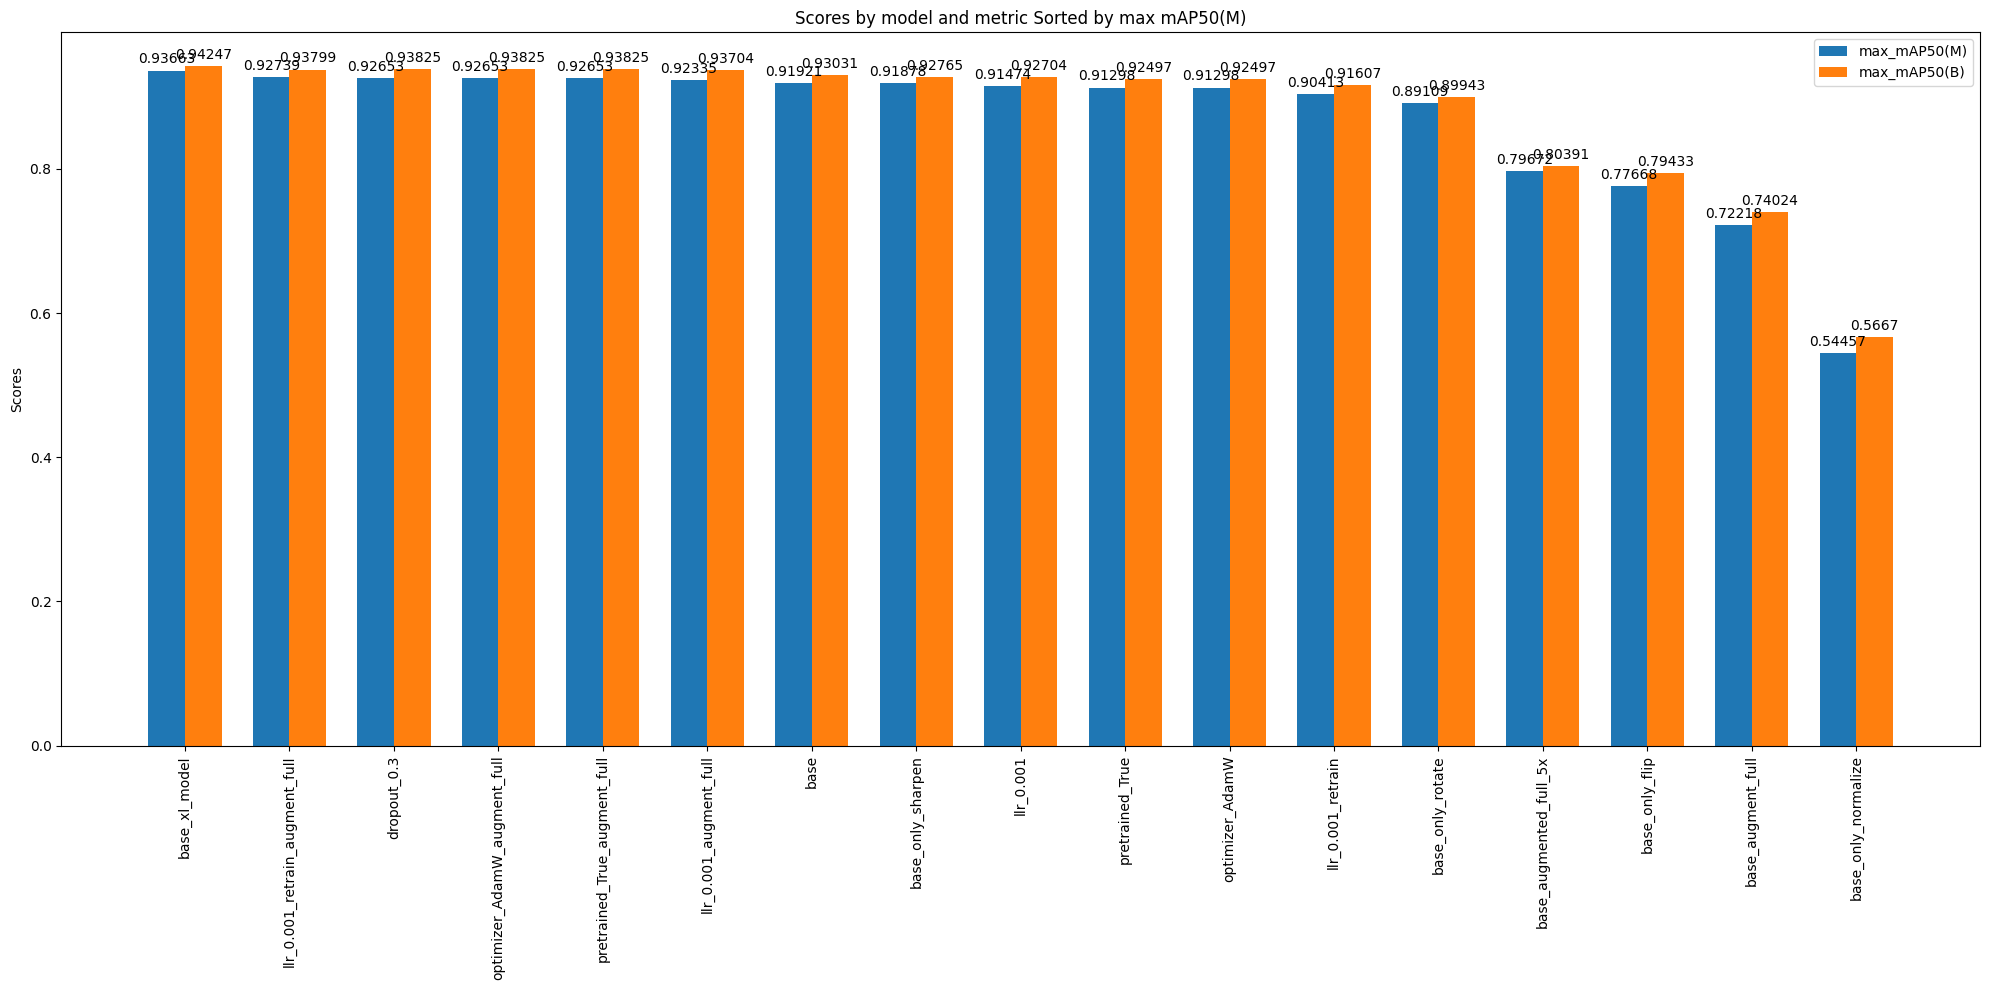

In [15]:
model_names = [model_dir.split("/")[-1] for model_dir in model_dirs]

# Combine the labels and corresponding values into a list of tuples
combined_M = list(zip(model_names, max_mAP50_M_values))

# Sort the list based on the value part of each tuple (in descending order)
sorted_combined_M = sorted(combined_M, key=lambda x: x[1], reverse=True)

# Get the sorted labels and corresponding values
sorted_labels_M, sorted_values_M = zip(*sorted_combined_M)

# Match the order of max_mAP50_B_values to the sorted max_mAP50_M_values
matched_values_B = [max_mAP50_B_values[model_names.index(label)] for label in sorted_labels_M]

fig, ax = plt.subplots(figsize=(20, 10))

width = 0.35  # the width of the bars
x = np.arange(len(sorted_labels_M))  # the label locations

rects1 = ax.bar(x - width/2, sorted_values_M, width, label='max_mAP50(M)')
rects2 = ax.bar(x + width/2, matched_values_B, width, label='max_mAP50(B)')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric Sorted by max mAP50(M)')
ax.set_xticks(x)
ax.set_xticklabels(sorted_labels_M, rotation='vertical')  # Set the rotation to 'vertical'
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


## Evaluation of Confusion Matrices and comparison to Paper with Mask R-CNN

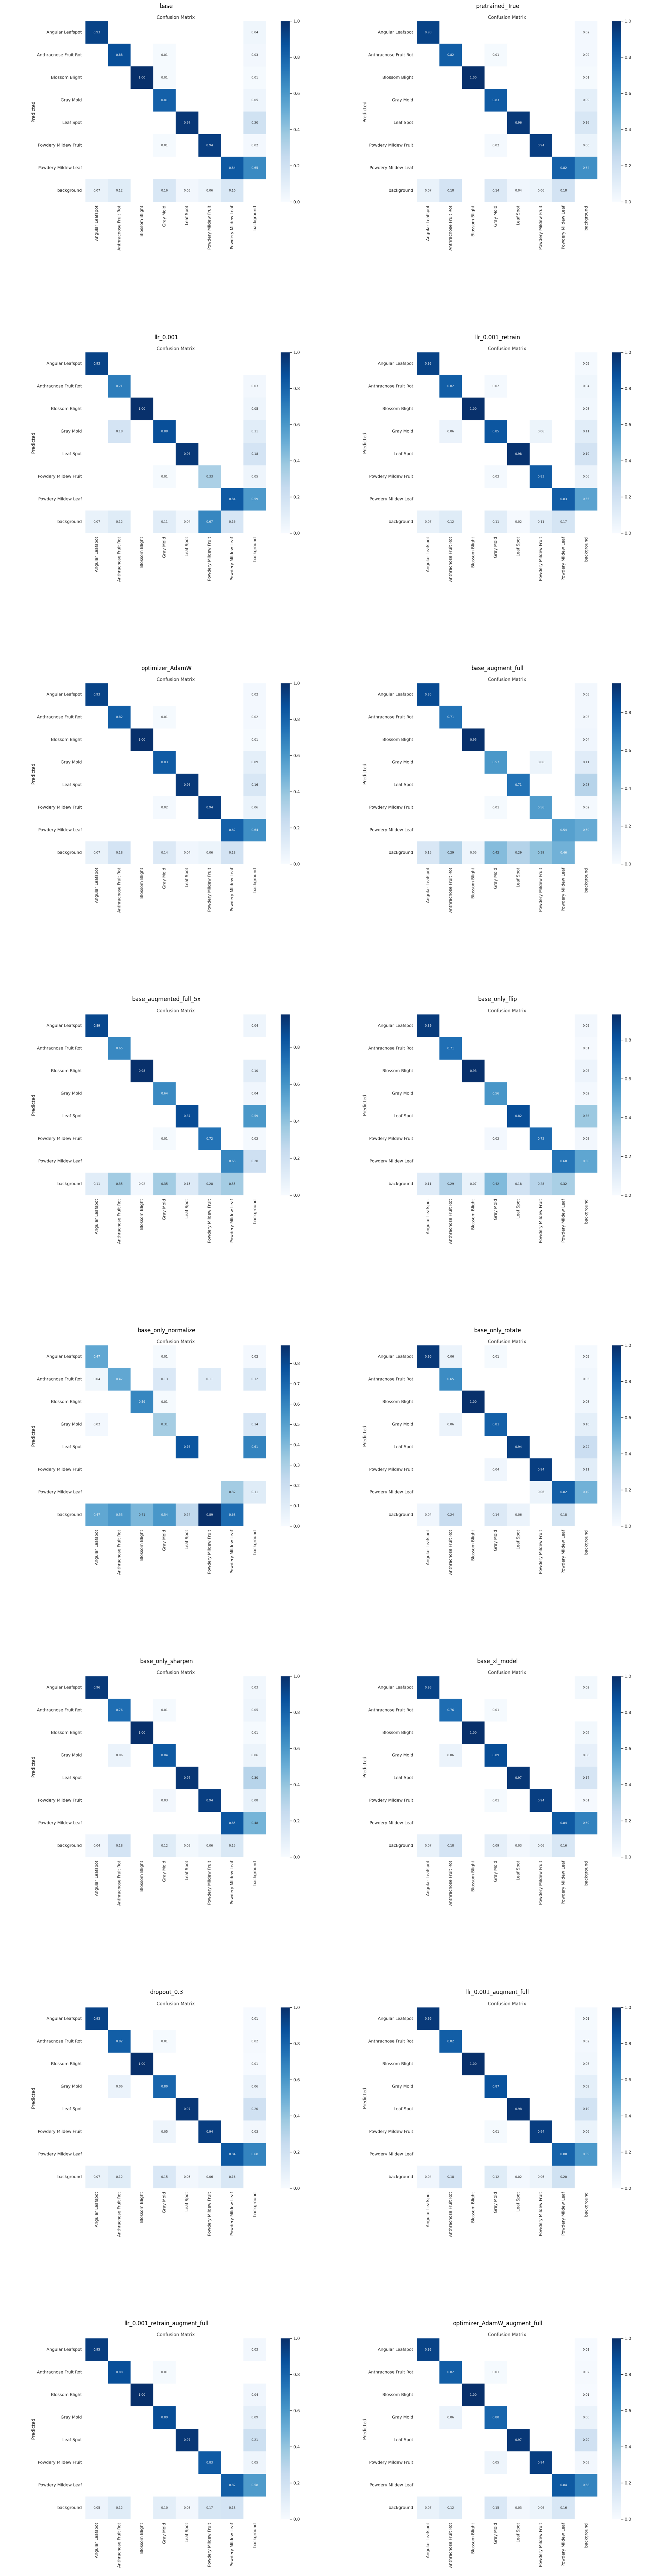

In [17]:
num_rows = int(np.ceil(len(model_dirs) / 2))
num_cols = 2
fig = plt.figure(figsize=(num_cols*10, num_rows*10))
gs = gridspec.GridSpec(num_rows, num_cols)
for idx, model_dir in enumerate(model_dirs):
    confusion_matrix_path = os.path.join(model_dir, "confusion_matrix.png")
    img = mpimg.imread(confusion_matrix_path)
    row = idx // num_cols
    col = idx % num_cols
    ax = fig.add_subplot(gs[row, col])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(model_dir.split("/")[-1])
if len(model_dirs) < num_rows * num_cols:
    for i in range(len(model_dirs), num_rows * num_cols):
        fig.delaxes(fig.axes[-1])

plt.tight_layout()
plt.show()
